In [1]:
import re
import math
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pio.renderers.default = "svg" # Save as static image => embed in jupyter notebook

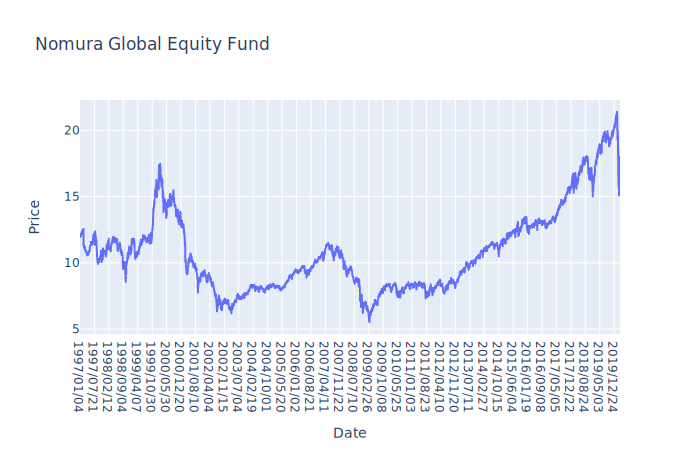

In [2]:
Data = pd.read_csv("Nomura_Global_Equity_Fund.csv")
fig = px.line(Data, x = "Date", y = "Price", title = 'Nomura Global Equity Fund')
fig.show()

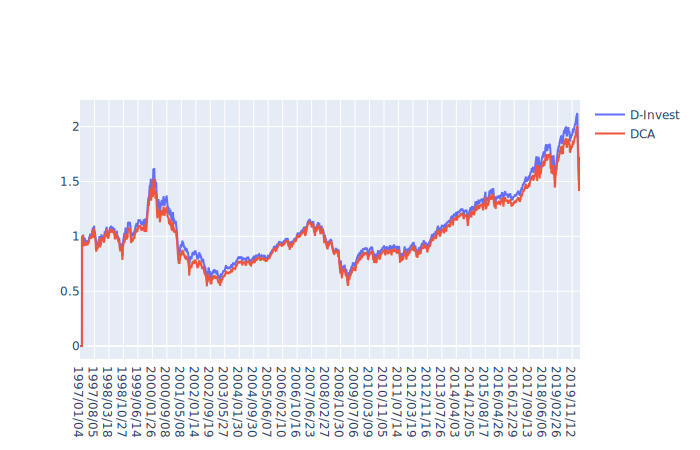

In [5]:
D_invest = investRoiDataFrame(investPriceAvg(percentDaysStrategDataFrame(10,10)))
dollarCostAveraging = investRoiDataFrame(investPriceAvg(percentDaysStrategDataFrame(100,30)))

fig = go.Figure()
fig.add_trace(go.Scatter(x=D_invest["Date"], y=D_invest["Price"], mode='lines', name='D-Invest'))
fig.add_trace(go.Scatter(x=dollarCostAveraging["Date"], y=dollarCostAveraging["Price"], mode='lines', name='DCA'))

fig.show()

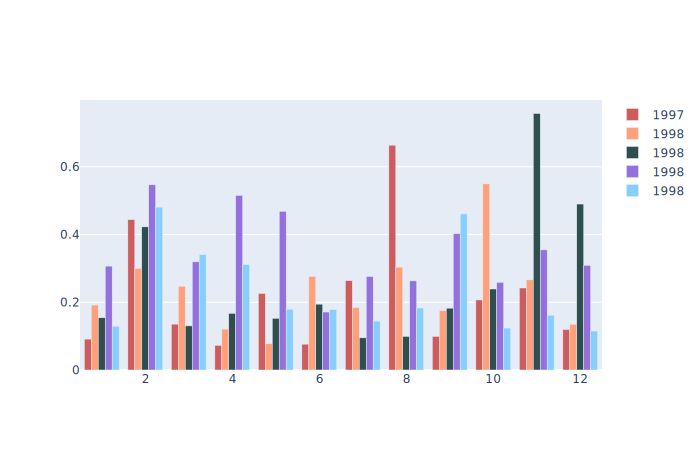

In [6]:
std1997 = monthStandardDeviation(1997)
std1998 = monthStandardDeviation(1998)
std1999 = monthStandardDeviation(1999)
std2000 = monthStandardDeviation(2000)
std2001 = monthStandardDeviation(2001)

monthStr = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

fig = go.Figure()
fig.add_trace(go.Bar(x=monthStr, y=std1997["Std"],name='1997',marker_color='indianred'))
fig.add_trace(go.Bar(x=monthStr, y=std1998["Std"],name='1998',marker_color='lightsalmon'))
fig.add_trace(go.Bar(x=monthStr, y=std1999["Std"],name='1998',marker_color='DarkSlateGrey'))
fig.add_trace(go.Bar(x=monthStr, y=std2000["Std"],name='1998',marker_color='MediumPurple'))
fig.add_trace(go.Bar(x=monthStr, y=std2001["Std"],name='1998',marker_color='LightSkyBlue'))

fig.show()

In [4]:
def monthStandardDeviation(year):
    '''Calculate month standard deviation of one year'''
    monthStr = ["/01", "/02", "/03", "/04", "/05", "/06", "/07", "/08", "/09", "/10", "/11", "/12"]
    monthDataFrame = pd.DataFrame(columns = ["Date", "Std"])
    
    for i in range (12):
        monthPrice = []
        
        for j in range (Data["Date"].size):
            if (str(str(year) + monthStr[i]) in Data["Date"][j]):
                monthPrice.append(Data["Price"][j])
            
        monthStd = np.std(np.array(monthPrice))
        monthDataFrame.loc[i] = [str(str(year) + monthStr[i]), monthStd]
    return monthDataFrame

def yearStdBarChart(start, end):
    '''Plot standard deviation bar chart between start year and end year'''
    stdBarDict = {}
    monthStr = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]

    for i in range(end - start + 1):
        stdBarDict[str(start + i)] = np.array(monthStandardDeviation(start + i)["Std"])

    yearDataFrame = pd.DataFrame(data = stdBarDict, index = monthStr);
    yearDataFrame.plot.bar(title = str(start) + " ~ " + str(end) + " standard deviation", figsize=(15,5), legend=False);

def percentDaysStrategy(percent, days):
    '''Return additional buying point of Percent-Days Strategy'''
    percentDataFrame = pd.DataFrame(columns = ["Date", "Price"])
    index = 0
    
    for i in range(days, Data["Price"].size):
        daysArr = np.array(Data["Price"][i - days: i])
        rateOfDates = Data["Price"][i] / daysArr
        smallThenPercent = np.less_equal(rateOfDates, (100 - percent) / 100)
        
        if (True in smallThenPercent):
            percentDataFrame.loc[index] = [Data["Date"][i], Data["Price"][i]]
            index += 1
    return percentDataFrame

def percentDaysStrategDataFrame(percent, days):
    '''Return regular buying point and additional buying point'''
    strategyDataFrame = pd.DataFrame(columns = ["Date", "Price"])
    regularDataFrame = pd.DataFrame(columns = ["Date", "Price"])

    for i in range(Data["Price"].size):
        if (re.search("01$", str(Data["Date"][i]))):
            regularDataFrame.loc[i] = [Data["Date"][i], Data["Price"][i]]

    additionalBuyingDataFrame = percentDaysStrategy(percent,days)
    strategyDataFrame = pd.concat([regularDataFrame, additionalBuyingDataFrame], axis=0, ignore_index=True)
    strategyDataFrame = strategyDataFrame.sort_values(by=['Date']).drop_duplicates(subset = "Date", keep = "last").reset_index(drop=True)
    
    return strategyDataFrame

def investPriceAvg(dataFrame):
    '''Return price average dataframe'''
    investPriceAvgDataFrame = pd.DataFrame(columns = ["Date", "Price"])
    priceAvg = 0
    for i in range(dataFrame["Price"].size):
        priceAvg = (priceAvg * len(investPriceAvgDataFrame["Price"]) + dataFrame["Price"][i]) / (len(investPriceAvgDataFrame["Price"]) + 1)
        investPriceAvgDataFrame.loc[i] = [dataFrame["Date"][i], priceAvg]
    return investPriceAvgDataFrame

def investRoiDataFrame(dataFrame):
    '''Return roi dataframe'''
    roiDataFrame = pd.DataFrame(columns = ["Date", "Price"])
    j = 0
    priceAvg = math.inf
    
    for i in range (Data["Date"].size):
        if (Data["Date"][i] < dataFrame["Date"][j]):
            roi = Data["Price"][i] / priceAvg
            
        elif (Data["Date"][i] == dataFrame["Date"][j]):
            priceAvg = dataFrame["Price"][j]
            roi = Data["Price"][i] / priceAvg
            j = j + 1 if j + 1 < len(dataFrame["Price"]) else j
            
        else:
            roi = Data["Price"][i] / dataFrame["Price"].tolist()[-1]
            
        roiDataFrame.loc[i] = [Data["Date"][i], roi]
    return roiDataFrame